### Stock Forecaster

In [1]:
from lib.forecast import StockForecaster
import matplotlib.pyplot as plt
import pandas as pd

In [14]:
import requests
from json import dumps
from os import getenv

def get_data_from_polygon(ticker, candle_size, timeframe="minute", api_key=None):
    
    # get from datetime
    year = 2023
    month = "06"
    day = "24"
    
    start_date = f"{year-2}-{month}-{day}"
    end_date = f"{year}-{month}-{day}"
    
    ticker = ticker.upper()
    url = (
        f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/{candle_size}/{timeframe}/{start_date}/"
        f"{end_date}?adjusted=true&sort=asc&limit=50000&apiKey={api_key}"
    )
    d = requests.get(url)
    raw_data = d.json()

    fn = f"./_data/{ticker}-{candle_size}-{timeframe}-{start_date}-{end_date}.json"
    with open(fn, "w") as outf:
        try:
            outf.write(dumps(raw_data["results"]))
        except Exception as ex:
            print(ex)
            print(raw_data)

    return fn

ticker = "nvda"
candlesize = 30

key = getenv("POLYKEY")
fn = get_data_from_polygon(ticker, candlesize, timeframe="minute", api_key=key)
print(fn)

./_data/NVDA-30-minute-2021-06-24-2023-06-24.json


In [3]:
# train_on = ["v", "vw", "n", "o", "c", "h", "l"]
train_on = ["v", "vw", "n", "c"]
target = "c"
chart_train_column = 1

sf = StockForecaster(
    epochs=700,lr=0.001, 
    num_predictions=60, num_training_sequences=300,
    hidden_size=10, 
    gpu_device="mps", 
    train_on=train_on, target=target
)
sf.load(fn, start_at = 0)

# sf = StockForecaster(epochs=900,lr=0.001, hidden_size=20, gpu_device="mps")
# sf.load("AAPL.csv", start_at = 8600)

sf.prepare()
sf.create_model()
# len(sf.raw_data)

Index(['v', 'vw', 'n', 'c'], dtype='object')


In [4]:
sf.raw_data.head(5)

,v,vw,n,c
0,858,84.3920,13,84.43
1,2056,84.4377,65,84.43
2,2155,84.3264,31,84.37
3,2138,84.3450,24,84.32
4,100,84.2700,1,84.27


<Axes: >

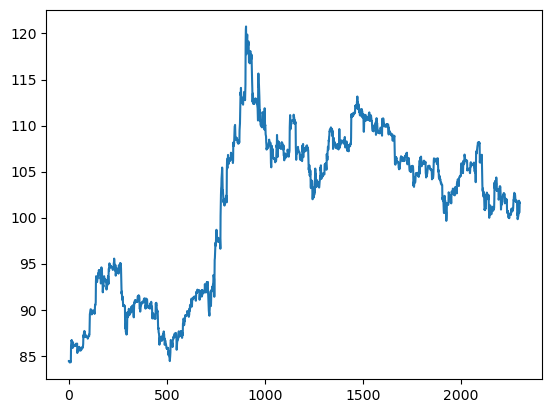

In [5]:
sf.raw_data["c"].plot()

#### Train Model

In [6]:
loss_data, test_loss_data = sf.train()

Epoch: 0, train loss: 0.2868639826774597, test loss: 0.2551972270011902
Epoch: 100, train loss: 0.005239960737526417, test loss: 0.005013147369027138
Epoch: 200, train loss: 0.0040902947075665, test loss: 0.005019658245146275
Epoch: 300, train loss: 0.003848185297101736, test loss: 0.005095058586448431
Epoch: 400, train loss: 0.0036926621105521917, test loss: 0.0052829310297966
Epoch: 500, train loss: 0.0035822035279124975, test loss: 0.005478825885802507
Epoch: 600, train loss: 0.003488540882244706, test loss: 0.005650159902870655


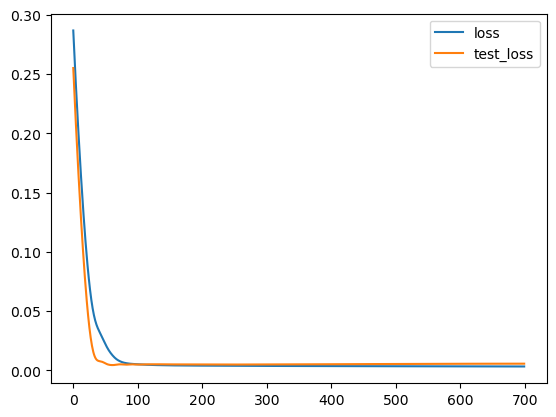

In [7]:
plt.plot(loss_data, label="loss")
plt.plot(test_loss_data, label="test_loss")
plt.legend()
plt.show()

#### Validate

<Axes: >

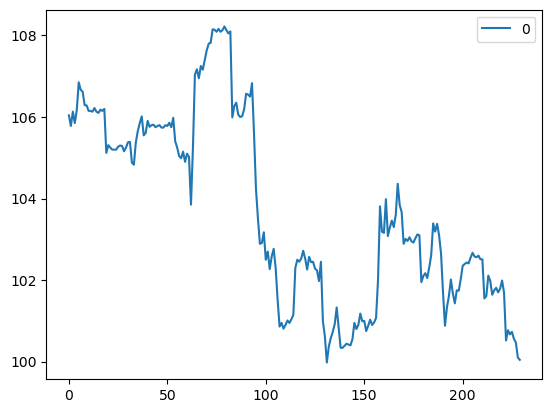

In [8]:
train_data = sf.ss.inverse_transform(sf.X_train_tensors.data.numpy()[:,0,:])[:,chart_train_column]
test_data = sf.mm.inverse_transform(sf.y_test_tensors)[:,chart_train_column]

train_predict = sf.lstm(sf.X_test_tensors) 
data_predict = sf.mm.inverse_transform(train_predict.data.numpy())[:,0]
pd.DataFrame(test_data).plot()

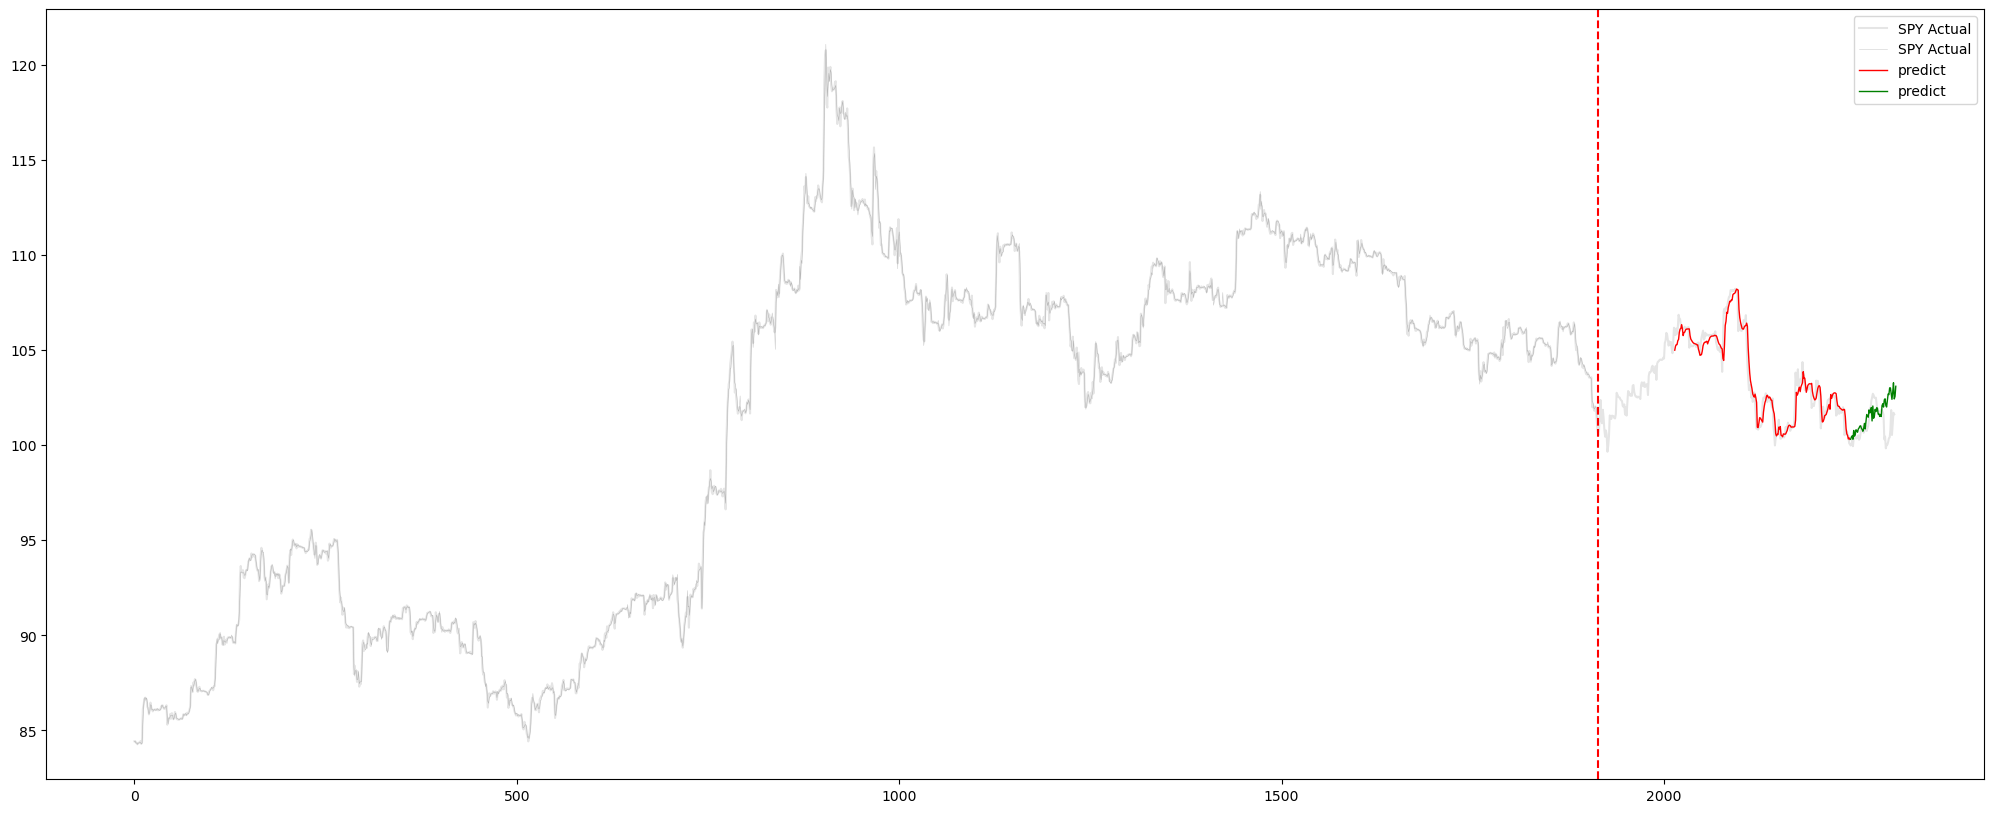

In [9]:
tdata_len = len(train_data)

plt.figure(figsize=(25,10)) #plotting

plt.plot(sf.mm.inverse_transform(sf.y_train), "k", label="SPY Actual", alpha=0.1)

plt.plot(train_data, "k", label="SPY Actual", alpha=0.2,linewidth=0.4)

# td = [None] * (tdata_len + 100)
# td.extend(test_data)
# plt.plot(td, "b", label="test", alpha=0.2,linewidth=0.4)

dp = [None] * (tdata_len + 100)
dp.extend(data_predict)
plt.plot(dp, "r", label="predict",linewidth=1)

test_predict = sf.lstm(sf.X_test_tensors[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.detach().numpy()
test_predict = sf.mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

dp = [None] * (tdata_len + 100 + len(data_predict))
dp.extend(test_predict)
plt.plot(dp, "g", label="predict",linewidth=1)


plt.axvline(x=len(train_data), c='r', linestyle='--') # size of the training set

plt.legend()

plt.savefig(f"./images/full_prediction-{ticker}-{candlesize}.png", dpi=300)

plt.show()

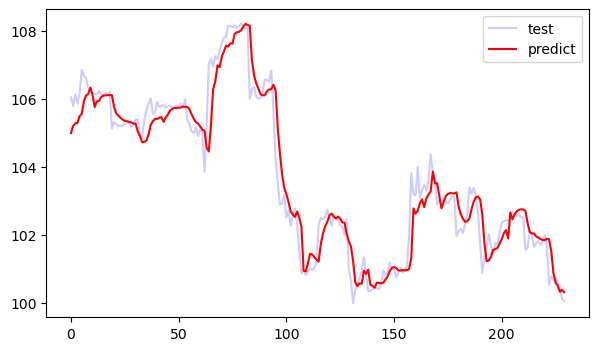

In [10]:
plt.figure(figsize=(7,4)) #plotting

td = test_data
plt.plot(td, "b", label="test", alpha=0.2)

dp = data_predict
plt.plot(dp, "r", label="predict")

plt.legend()
plt.savefig(f"./images/prediction-{ticker}-{candlesize}.png", dpi=300)

plt.show()

### Future Price

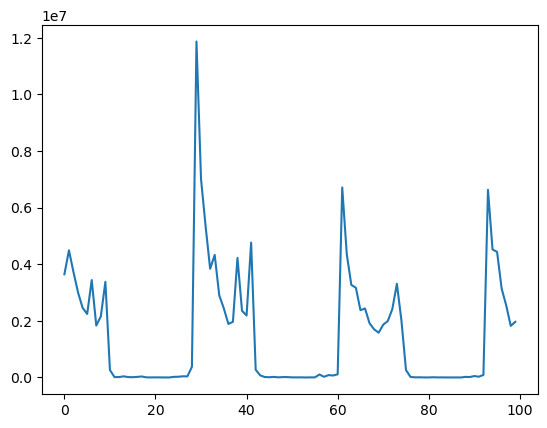

In [11]:
ds = sf.X_test_tensors[-1].unsqueeze(0)
plt.plot(sf.ss.inverse_transform(ds.detach().numpy()[0])[:, 0])

In [12]:
len(sf.X_train_tensors.data.numpy()) + len(sf.X_test_tensors.data.numpy())

2144

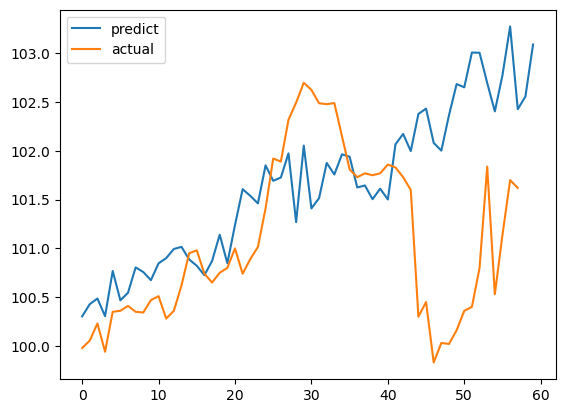

In [13]:
test_predict = sf.lstm(sf.X_test_tensors[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.detach().numpy()
test_predict = sf.mm.inverse_transform(test_predict)
test_predict = test_predict[0].tolist()

known_length = len(sf.X_train_tensors.data.numpy()) + len(sf.X_test_tensors.data.numpy())
test_target = sf.raw_data.c[known_length+100:].reset_index(drop=True)
# test_target = sf.y_test_tensors[-1].detach().numpy() # last sample again
# test_target = sf.mm.inverse_transform(test_target.reshape(1, -1))
# test_target = test_target[0].tolist()

plt.plot(test_predict, label="predict")
plt.plot(test_target, label="actual")
plt.legend()
plt.savefig(f"./images/prediction_future-{ticker}-{candlesize}.png", dpi=300)

plt.show()